# Task definition
Implement LSTM Sentiment Tagger for imdb reviews dataset.

1. (5pt) Fill missing code below
    * 1pt implement vectorization
    * 2pt implement \_\_init\_\_ and forward methods of models
    * 2pt implement collate function
2. (4pt) Implement training loop, choose proper loss function, use clear ml for max points.
    * 2pts is a baseline for well written, working code
    * 2pts if clear ml used properly
3. (3pt) Train the models (find proper hyperparams). Make sure you are not overfitting or underfitting. Visualize training of your best model (plot training, and test loss/accuracy in time). Your model should reach at least 87% accuracy. For max points it should exceed 89%. 
    * 1pt for accuracy above 89%
    * 1pt for accuracy above 87%
    * 1pt for visualizations

Remarks:
* Use embeddings of size 50
* Use 0.5 threshold when computing accuracy.
* Use supplied dataset for training and evaluation.
* You do not have to use validation set.
* You should monitor overfitting during training.
* For max points use clear ml to store and manage logs from your experiments. 
* We encourage to use pytorch lightning library (Addtional point for using it - however the sum must not exceed 12)

[Clear ML documentation](https://clear.ml/docs/latest/docs/)

[Clear ML notebook exercise from bootcamp](https://colab.research.google.com/drive/1wtLb4gg8beLS7smcyJlOZppn6_rQvSxL?usp=sharing)

In [5]:
!pip install clearml

import os
from collections import defaultdict

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torchtext
from clearml import Task

import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset, DataLoader

In [6]:

web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = 'ZVXXHY04U8N06IDW4ZJU'#@param {type:"string"}
secret_key = '0hxBfqBP373jENJLMAGzpcO4ZA8lO9oCN1aJaaHFALvz3gZLYV'#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

In [7]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
!tar -xvzf imdb_dataset.gz
data = pd.read_csv("imdb_dataset.csv")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 97 kB 723 kB/s eta 0:00:01
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=47de8ff17e5a6c7c779bd69daea5e017b113b573d487ad24fbc8ba1e4e08a8bc
  Stored in directory: /home/bj394093/.cache/pip/wheels/68/11/97/886e5796b655bf28bf4a0d75e933ea71c6d7d34be701168d1d
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1hK-3iiRPlbePb99Fe-34LJNZ5yB-nduq
To: /home/bj394093/homework3/imdb_dataset.gz
100%|███████████████████████████████████████| 77.0M/77.0M [00:00<00:00, 101MB/s]
imdb_dataset.csv


In [8]:
data

,Unnamed: 0,text,split,id,stars,sentiment,tokenized
0,0,"Gary Cooper, (Michael Brandon) played the role...",test,6182,8,1.0,"gary cooper , ( michael brandon ) played the r..."
1,1,"This film is a tapestry, a series of portraits...",test,7654,10,1.0,"this film is a tapestry , a series of portrait..."
2,2,i see there are great reviews of this film alr...,test,10435,7,1.0,i see there are great reviews of this film alr...
3,3,This film says everything there is to say abou...,test,10476,10,1.0,this film says everything there is to say abou...
4,4,Apparently this Australian film based on Nevil...,test,9769,9,1.0,apparently this australian film based on nevil...
...,...,...,...,...,...,...,...
99995,99995,Wow! I am still in absolute shock from this fi...,unsup,13698,0,NaN,wow ! i am still in absolute shock from this f...
99996,99996,As someone who always likes to solve the New Y...,unsup,6887,0,NaN,as someone who always likes to solve the new y...
99997,99997,What can i say positive about this movie? Abso...,unsup,13748,0,NaN,what can i say positive about this movie ? abs...
99998,99998,I am really amazed how bad acting can really b...,unsup,48085,0,NaN,i am really amazed how bad acting can really b...


2951


No handles with labels found to put in legend.


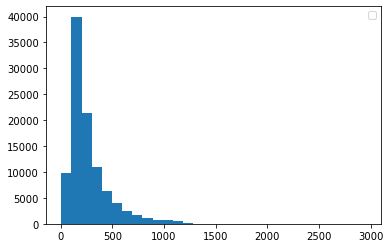

In [68]:
import matplotlib.pyplot as plt

tokenized_data = [seq.split() for seq in data['tokenized']]
lens = [len(review) for review in tokenized_data]
print(max(lens))
plt.hist(lens, bins=30)
plt.show()

In [42]:
from torch.nn.utils.rnn import pad_sequence


PADDING_VALUE = 0

class NaiveVectorizer:
    def __init__(self, tokenized_data, **kwargs):
        """Converts data from string to vector of ints that represent words. 
        Prepare lookup dict (self.wv) that maps token to int. Reserve index 0 for padding.
        """
        tokenized_data = [seq.split() for seq in tokenized_data]
        ### Your code goes here ###
        tokens = set()
        for review in tokenized_data:
            for word in review:
                tokens.add(word)
        tokens = sorted(list(tokens))
        self.wv = {tokens[i]:i+1 for i in range(len(tokens))}

        ##################################

    def vectorize(self, tokenized_seq):
        """Converts sequence of tokens into sequence of indices.
        If the token does not appear in the vocabulary(self.wv) it is ommited
        Returns torch tensor of shape (seq_len,) and type long."""
        ### Your code goes here ###
        vector = []
        for word in tokenized_seq:
            if word in self.wv:
                vector.append(self.wv[word])
        vector = torch.tensor(vector, dtype=torch.long)

        return vector
        ##################################

class ImdbDataset(Dataset):
    SPLIT_TYPES = ["train", "test", "unsup"]

    def __init__(self, data, preprocess_fn, split="train"):
        super(ImdbDataset, self).__init__()
        if split not in self.SPLIT_TYPES:
            raise AttributeError(f"No such split type: {split}")

        self.split = split
        self.label = [i for i, c in enumerate(data.columns) if c == "sentiment"][0]
        self.data_col = [i for i, c in enumerate(data.columns) if c == "tokenized"][0]
        self.data = data[data["split"] == self.split]
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = self.preprocess_fn(self.data.iloc[idx, self.data_col].split())
        label = self.data.iloc[idx, self.label]
        return (seq, label)

naive_vectorizer = NaiveVectorizer(data.loc[data["split"] == "train", "tokenized"])

def get_datasets():
    train_dataset = ImdbDataset(data, naive_vectorizer.vectorize)
    test_dataset = ImdbDataset(data, naive_vectorizer.vectorize, split="test")
        
    return train_dataset, test_dataset

def custom_collate_fn(pairs):
    """This function is supposed to be used by dataloader to prepare batches
    Input: list of tuples (sequence, label)
    Output: sequences_padded_to_the_same_lenths, original_lenghts_of_sequences, lables.
    torch.nn.utils.rnn.pad_sequence might be usefull here
    """
    ### Your code goes here ###
    seqcs = pad_sequence([tup[0] for tup in pairs])
    lengths = [len(tup[0]) for tup in pairs]
    labels = [tup[1] for tup in pairs]
    
    #################################
    return seqcs, lengths, labels

In [49]:
"""Implement LSTMSentimentTagger. 
The model should use a LSTM module.
Use torch.nn.utils.rnn.pack_padded_sequence to optimize processing of sequences.
When computing vocab_size of embedding layer remeber that padding_symbol counts to the vocab.
Use sigmoid activation function.
"""
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

class LSTMSentimentTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMSentimentTagger, self).__init__()
        self.hidden_dim = hidden_dim
        ### Your code goes here ###
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigm = nn.Sigmoid()

        #################################

    def forward(self, reviews, lengths, mode=0):
        ### Your code goes here ###
        embeds = self.word_embeddings(reviews)
        packed = pack_padded_sequence(embeds, lengths, enforce_sorted=False)
        lstm_out, (h, c) = self.lstm(packed)
        b_size = h.shape[1] 
        if mode==0:
            out = self.fc(h.view(-1, self.hidden_dim))
        elif mode==1:
            out = self.fc1(h.view(-1, self.hidden_dim))
            out = F.relu(out)
            out = self.fc2(out)
        elif mode==2:
            out = self.fc1(h.view(-1, self.hidden_dim))
            out = self.dropout(out)
            out = F.relu(out)
            out = self.fc2(out)
        else:
            print('LSTMSentimentTagger: invalid mode', mode)   
        out = self.sigm(out)
        out = out.view(b_size)
        #################################
        return out

# Trainig loop and visualizations


In [66]:
class LSTMTrainer(object):
    def __init__(self, batch_size, hidden_dim, lr=0.01):
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        train_dataset, test_dataset = get_datasets()
        self.train_dataset, self.test_dataset = train_dataset, test_dataset
        self.trainloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True)
        self.testloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True)
        self.lr = lr
    
    def train(self, epochs=4, log_interval=100, logger=None, mode=0, early_stopping=False):
        n = len(self.train_dataset)
        model = LSTMSentimentTagger(self.batch_size, self.hidden_dim, len(naive_vectorizer.wv)+1)

        criterion = nn.BCELoss()
        if type(self.lr)==tuple:  # variable lr
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr[0])
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)

        accuracies = []
        losses = []
        iteration = 0
        for epoch in range(epochs):
            running_loss = 0.0
            total_loss = 0.0

            for i, data in enumerate(self.trainloader, 0):
                optimizer.zero_grad()
                reviews, lengths, labels = data
                scores = model(reviews, lengths, mode)
                labels = torch.tensor(labels, dtype=torch.float)
                loss = criterion(scores, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % log_interval == log_interval-1:
                    print('Epoch %d, %d/%d, loss: %.3f' %
                          (epoch + 1, (i+1)*self.batch_size, n, running_loss / log_interval))
                    total_loss += running_loss
                    if logger is not None:
                        logger.report_scalar(title='Loss', series='Train', iteration=iteration, value=running_loss/log_interval)
                    iteration += 1
                    running_loss = 0.0
            total_loss /= i 
            losses.append(total_loss)

            correct = 0
            with torch.no_grad():
                for data in self.testloader:
                    reviews, lengths, labels = data
                    scores = model(reviews, lengths, mode)
                    predicted = torch.round(scores)
                    labels = torch.tensor(labels)
                    correct += (predicted == labels).sum().item()
            acc = 100 * correct / len(self.test_dataset)
            if logger is not None:
                logger.report_scalar(title='Accuracy', series='Test', iteration=epoch+1, value=acc)
            print(f'Accuracy of the network: {acc}')
            accuracies.append(acc)
            if early_stopping and epoch > 0:
                if acc < accuracies[-2]:
                    print(f'Stopped after {epoch+1} epochs')
                    return accuracies, losses
            if epoch==0 and type(self.lr)==tuple:  # change lr after first epoch
                optimizer = torch.optim.Adam(model.parameters(), lr=self.lr[1])
        return accuracies, losses

ClearML Task: created new task id=914edb929425428781411ed84a35dcaf
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/914edb929425428781411ed84a35dcaf/output/log
2022-01-14 22:55:55,063 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.719
Epoch 1, 2000/25000, loss: 0.694
Epoch 1, 3000/25000, loss: 0.689
Epoch 1, 4000/25000, loss: 0.686
Epoch 1, 5000/25000, loss: 0.682
Epoch 1, 6000/25000, loss: 0.671
Epoch 1, 7000/25000, loss: 0.674
Epoch 1, 8000/25000, loss: 0.673
Epoch 1, 9000/25000, loss: 0.657
Epoch 1, 10000/25000, loss: 0.653
Epoch 1, 11000/25000, loss: 0.648
Epoch 1, 12000/25000, loss: 0.627
Epoch 1, 13000/25000, loss: 0.611
Epoch 1, 14000/25000, loss: 0.581
Epoch 1, 15000/25000, loss: 0.586
Epoch 1, 16000/25000, loss: 0.581
Epoch 1, 17000/25000, loss: 0.569
Epoch 1, 18000/25000, loss:

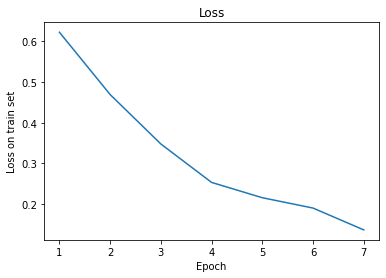

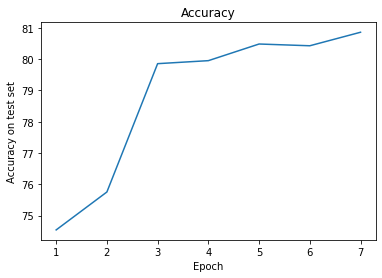

ClearML Task: created new task id=256bc8e0c572407499ea3de6d9c8bae1
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/256bc8e0c572407499ea3de6d9c8bae1/output/log
2022-01-14 23:24:07,711 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.689
Epoch 1, 2000/25000, loss: 0.691
Epoch 1, 3000/25000, loss: 0.683
Epoch 1, 4000/25000, loss: 0.681
Epoch 1, 5000/25000, loss: 0.680
Epoch 1, 6000/25000, loss: 0.672
Epoch 1, 7000/25000, loss: 0.668
Epoch 1, 8000/25000, loss: 0.667
Epoch 1, 9000/25000, loss: 0.649
Epoch 1, 10000/25000, loss: 0.632
Epoch 1, 11000/25000, loss: 0.625
Epoch 1, 12000/25000, loss: 0.593
Epoch 1, 13000/25000, loss: 0.601
Epoch 1, 14000/25000, loss: 0.604
Epoch 1, 15000/25000, loss: 0.595
Epoch 1, 16000/25000, loss: 0.570
Epoch 1, 17000/25000, loss: 0.517
Epoch 1, 18000/25000, loss:

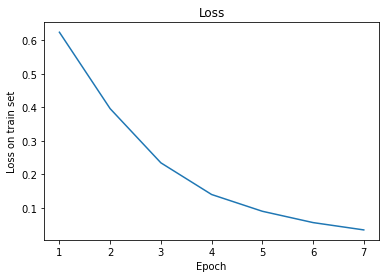

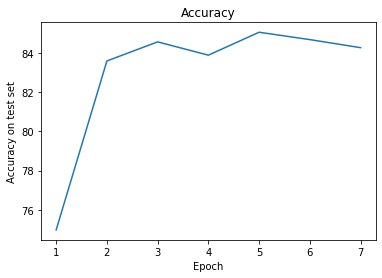

ClearML Task: created new task id=19c88df29fd342dfafc1298c5679e3b9
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/19c88df29fd342dfafc1298c5679e3b9/output/log
2022-01-14 23:53:20,361 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.695
Epoch 1, 2000/25000, loss: 0.686
Epoch 1, 3000/25000, loss: 0.695
Epoch 1, 4000/25000, loss: 0.679
Epoch 1, 5000/25000, loss: 0.671
Epoch 1, 6000/25000, loss: 0.663
Epoch 1, 7000/25000, loss: 0.634
Epoch 1, 8000/25000, loss: 0.736
Epoch 1, 9000/25000, loss: 0.686
Epoch 1, 10000/25000, loss: 0.679
Epoch 1, 11000/25000, loss: 0.681
Epoch 1, 12000/25000, loss: 0.667
Epoch 1, 13000/25000, loss: 0.644
Epoch 1, 14000/25000, loss: 0.634
Epoch 1, 15000/25000, loss: 0.630
Epoch 1, 16000/25000, loss: 0.594
Epoch 1, 17000/25000, loss: 0.593
Epoch 1, 18000/25000, loss:

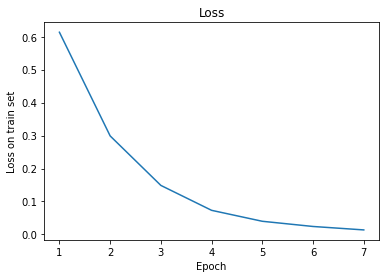

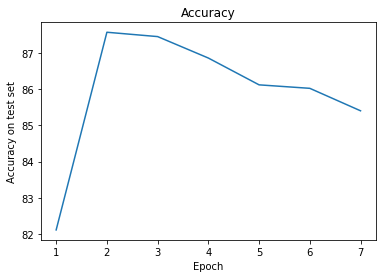

ClearML Task: created new task id=665c4acab7b24786ac629b616dab32c6
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/665c4acab7b24786ac629b616dab32c6/output/log
2022-01-15 00:24:28,552 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.692
Epoch 1, 2000/25000, loss: 0.679
Epoch 1, 3000/25000, loss: 0.667
Epoch 1, 4000/25000, loss: 0.655
Epoch 1, 5000/25000, loss: 0.648
Epoch 1, 6000/25000, loss: 0.678
Epoch 1, 7000/25000, loss: 0.653
Epoch 1, 8000/25000, loss: 0.633
Epoch 1, 9000/25000, loss: 0.634
Epoch 1, 10000/25000, loss: 0.632
Epoch 1, 11000/25000, loss: 0.579
Epoch 1, 12000/25000, loss: 0.679
Epoch 1, 13000/25000, loss: 0.601
Epoch 1, 14000/25000, loss: 0.604
Epoch 1, 15000/25000, loss: 0.698
Epoch 1, 16000/25000, loss: 0.675
Epoch 1, 17000/25000, loss: 0.661
Epoch 1, 18000/25000, loss:

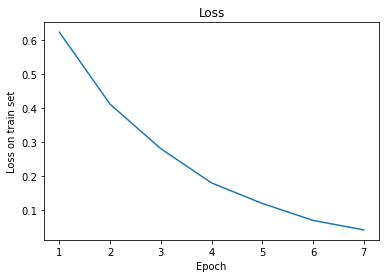

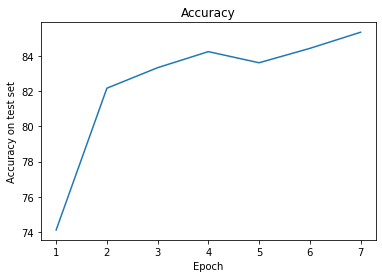

ClearML Task: created new task id=3a674c65eebc42089f022c266fd99f58
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/3a674c65eebc42089f022c266fd99f58/output/log
2022-01-15 01:05:09,510 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.711
Epoch 1, 2000/25000, loss: 0.688
Epoch 1, 3000/25000, loss: 0.685
Epoch 1, 4000/25000, loss: 0.679
Epoch 1, 5000/25000, loss: 0.671
Epoch 1, 6000/25000, loss: 0.653
Epoch 1, 7000/25000, loss: 0.652
Epoch 1, 8000/25000, loss: 0.650
Epoch 1, 9000/25000, loss: 0.638
Epoch 1, 10000/25000, loss: 0.612
Epoch 1, 11000/25000, loss: 0.615
Epoch 1, 12000/25000, loss: 0.618
Epoch 1, 13000/25000, loss: 0.595
Epoch 1, 14000/25000, loss: 0.572
Epoch 1, 15000/25000, loss: 0.584
Epoch 1, 16000/25000, loss: 0.582
Epoch 1, 17000/25000, loss: 0.554
Epoch 1, 18000/25000, loss:

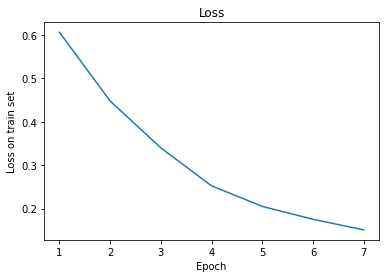

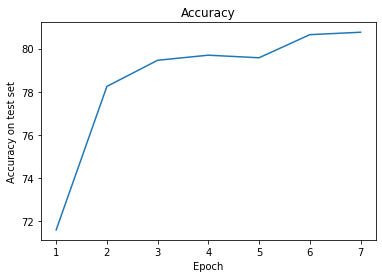

ClearML Task: created new task id=157993ee2cb5410c9b9fa4ed721a44ca
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/157993ee2cb5410c9b9fa4ed721a44ca/output/log
2022-01-15 01:33:36,531 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.687
Epoch 1, 2000/25000, loss: 0.688
Epoch 1, 3000/25000, loss: 0.675
Epoch 1, 4000/25000, loss: 0.672
Epoch 1, 5000/25000, loss: 0.667
Epoch 1, 6000/25000, loss: 0.655
Epoch 1, 7000/25000, loss: 0.654
Epoch 1, 8000/25000, loss: 0.644
Epoch 1, 9000/25000, loss: 0.615
Epoch 1, 10000/25000, loss: 0.586
Epoch 1, 11000/25000, loss: 0.586
Epoch 1, 12000/25000, loss: 0.534
Epoch 1, 13000/25000, loss: 0.515
Epoch 1, 14000/25000, loss: 0.520
Epoch 1, 15000/25000, loss: 0.472
Epoch 1, 16000/25000, loss: 0.506
Epoch 1, 17000/25000, loss: 0.482
Epoch 1, 18000/25000, loss:

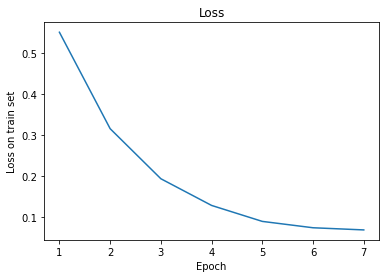

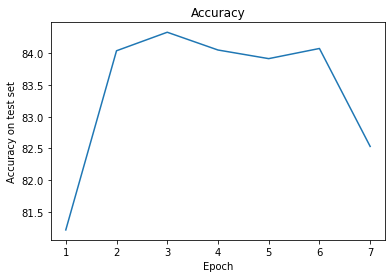

ClearML Task: created new task id=3308ca16efc540b4b2582d337c5db38b
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/3308ca16efc540b4b2582d337c5db38b/output/log
2022-01-15 02:02:38,396 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.697
Epoch 1, 2000/25000, loss: 0.683
Epoch 1, 3000/25000, loss: 0.691
Epoch 1, 4000/25000, loss: 0.667
Epoch 1, 5000/25000, loss: 0.647
Epoch 1, 6000/25000, loss: 0.627
Epoch 1, 7000/25000, loss: 0.595
Epoch 1, 8000/25000, loss: 0.590
Epoch 1, 9000/25000, loss: 0.608
Epoch 1, 10000/25000, loss: 0.605
Epoch 1, 11000/25000, loss: 0.576
Epoch 1, 12000/25000, loss: 0.649
Epoch 1, 13000/25000, loss: 0.603
Epoch 1, 14000/25000, loss: 0.585
Epoch 1, 15000/25000, loss: 0.569
Epoch 1, 16000/25000, loss: 0.481
Epoch 1, 17000/25000, loss: 0.503
Epoch 1, 18000/25000, loss:

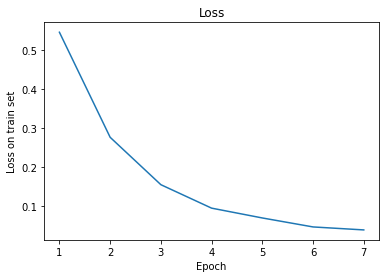

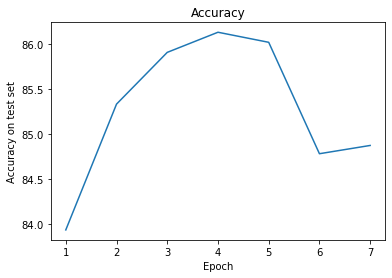

2022-01-15 02:33:10,880 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=3308ca16efc540b4b2582d337c5db38b, artifacts=[{'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/basic_6.3308ca16efc540b4b2582d337c5db38b/artifacts/notebook%20preview/notebook_3308ca16efc540b4b2582d337c5db38b.html', 'content_size': 880637, 'hash': 'b9f97f2a7320e403a93b224d6e5d079dd33630b228331d6ce7a97ed08ec7bd88', 'timestamp': 1642210267, 'type_data': {'preview': 'Click `FILE PATH` link', 'content_type': 'text/html'}, 'display_data': [('UPDATE', '2022-01-15 01:31:07')]}, {'key': 'notebook', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/basic_6.3308ca16efc540b4b2582d337c5db38b/artifacts/notebook/Copy_of_GSN_2021_22_Homework_RNN_student_version.ipynb', 'content_size': 282590, 'hash': '32f790597aa22c62e89460c805a1dd02563eb1f1527c664130a0dbfd3af26e77', 'ti

Epoch 7, 9000/25000, loss: 0.021
Epoch 7, 10000/25000, loss: 0.032
Epoch 7, 11000/25000, loss: 0.024
Epoch 7, 12000/25000, loss: 0.029
Epoch 7, 13000/25000, loss: 0.043
Epoch 7, 14000/25000, loss: 0.041
Epoch 7, 15000/25000, loss: 0.054
Epoch 7, 16000/25000, loss: 0.068
Epoch 7, 17000/25000, loss: 0.051
Epoch 7, 18000/25000, loss: 0.046
Epoch 7, 19000/25000, loss: 0.038
Epoch 7, 20000/25000, loss: 0.071
Epoch 7, 21000/25000, loss: 0.047
Epoch 7, 22000/25000, loss: 0.037
Epoch 7, 23000/25000, loss: 0.044
Epoch 7, 24000/25000, loss: 0.055
Epoch 7, 25000/25000, loss: 0.065
Accuracy of the network: 85.56


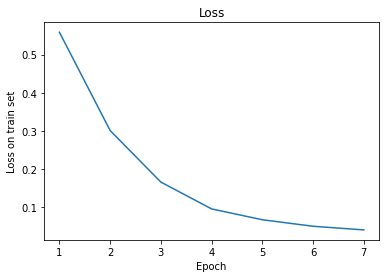

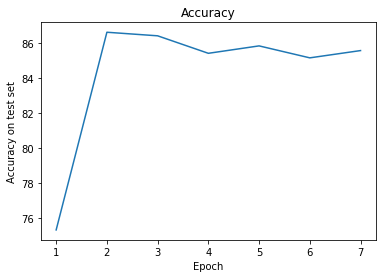

In [37]:
lrs = [0.005, 0.01]
hidden_dims = [4, 8, 16, 32]
epochs = 7
log_interval = 20
batch_size = 50
task_n = 0
for lr in lrs:
    for hidden_dim in hidden_dims:
        task_prefix = 'basic'
        task_name = task_prefix + '_' + str(task_n)
        task = Task.init(project_name='homework', task_name=task_name)
        task.set_parameters({'epochs':epochs, 'lr': lr, 'log_interval':log_interval, 
                             'batch_size':batch_size, 'hidden_dim':hidden_dim})
        logger = task.get_logger()
        trainer = LSTMTrainer(batch_size=batch_size, hidden_dim=hidden_dim, lr=lr)
        accs, losses = trainer.train(epochs=epochs, log_interval=log_interval, logger=logger)
        
        plt.plot(range(1,epochs+1), losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss on train set')
        plt.title('Loss')
        plt.show()
        plt.plot(range(1,epochs+1), accs)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy on test set')
        plt.title('Accuracy')
        plt.show()
        
        task.close()
        task_n += 1

ClearML Task: created new task id=bcbfec5315bd439da80b7c89bd0649c6
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/bcbfec5315bd439da80b7c89bd0649c6/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.690
2022-01-15 10:47:46,815 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 2000/25000, loss: 0.692
Epoch 1, 3000/25000, loss: 0.687
Epoch 1, 4000/25000, loss: 0.686
Epoch 1, 5000/25000, loss: 0.677
Epoch 1, 6000/25000, loss: 0.679
Epoch 1, 7000/25000, loss: 0.668
Epoch 1, 8000/25000, loss: 0.666
Epoch 1, 9000/25000, loss: 0.658
Epoch 1, 10000/25000, loss: 0.644
Epoch 1, 11000/25000, loss: 0.646
Epoch 1, 12000/25000, loss: 0.612
Epoch 1, 13000/25000, loss: 0.625
Epoch 1, 14000/25000, loss: 0.607
Epoch 1, 15000/25000, loss: 0.596
Epoch 1, 16000/25000, loss: 0.597
Epoch 1, 17000/25000, loss: 0.543
Epoch 1, 18000/25000, loss:

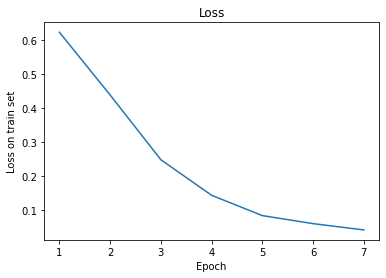

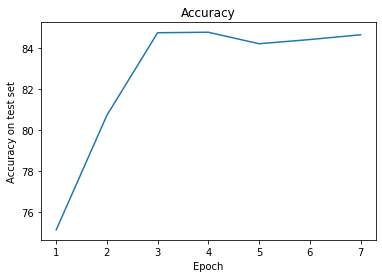

2022-01-15 11:15:02,724 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=bcbfec5315bd439da80b7c89bd0649c6, artifacts=[{'key': 'notebook', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/2fc_0.bcbfec5315bd439da80b7c89bd0649c6/artifacts/notebook/Copy_of_GSN_2021_22_Homework_RNN_student_version.ipynb', 'content_size': 361479, 'hash': 'bcdbc61f499b674ac5b9b3dbdf85e34e36530eac825d54178c2932f7393e7901', 'timestamp': 1642241699, 'type_data': {'preview': 'See `notebook preview` artifact'}, 'display_data': [('UPDATE', '2022-01-15 10:14:58')]}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/2fc_0.bcbfec5315bd439da80b7c89bd0649c6/artifacts/notebook%20preview/notebook_bcbfec5315bd439da80b7c89bd0649c6.html', 'content_size': 957734, 'hash': '529aed796af565b398bd8b2a8e218023d7f734748273f4baa22fc85e975c0853', 'timestamp': 1642241702, 't

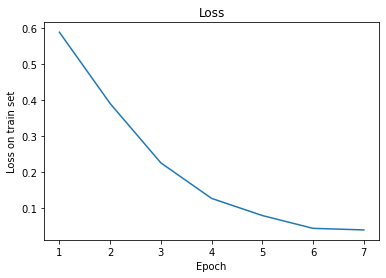

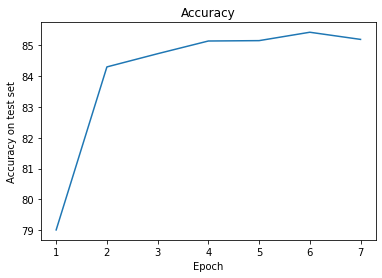

2022-01-15 11:44:50,651 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=871cff9182b849198f260895b56626bc, artifacts=[{'key': 'notebook', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/2fc_1.871cff9182b849198f260895b56626bc/artifacts/notebook/Copy_of_GSN_2021_22_Homework_RNN_student_version.ipynb', 'content_size': 400819, 'hash': '5e8a575098f38f235922e0215084fa91882ecb2e0175918616ca9dfb4dda405b', 'timestamp': 1642243486, 'type_data': {'preview': 'See `notebook preview` artifact'}, 'display_data': [('UPDATE', '2022-01-15 10:44:45')]}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.community.clear.ml/homework/2fc_1.871cff9182b849198f260895b56626bc/artifacts/notebook%20preview/notebook_871cff9182b849198f260895b56626bc.html', 'content_size': 1000518, 'hash': 'f0e2c6ede5830ac06c3ec84fcb9248013b87efaaeef4b7d59de9c6d20289de40', 'timestamp': 1642243490, '

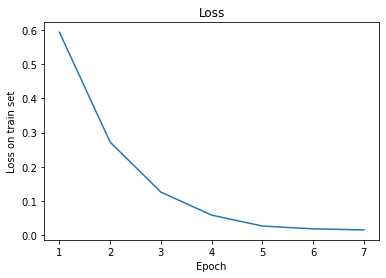

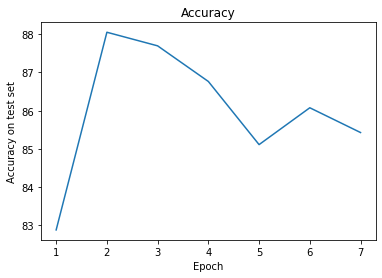

ClearML Task: created new task id=6f1240bd519542b19409e368a046aa45
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/6f1240bd519542b19409e368a046aa45/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-01-15 12:25:11,940 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 1000/25000, loss: 0.690
Epoch 1, 2000/25000, loss: 0.694
Epoch 1, 3000/25000, loss: 0.684
Epoch 1, 4000/25000, loss: 0.674
Epoch 1, 5000/25000, loss: 0.664
Epoch 1, 6000/25000, loss: 0.666
Epoch 1, 7000/25000, loss: 0.661
Epoch 1, 8000/25000, loss: 0.645
Epoch 1, 9000/25000, loss: 0.619
Epoch 1, 10000/25000, loss: 0.612
Epoch 1, 11000/25000, loss: 0.568
Epoch 1, 12000/25000, loss: 0.539
Epoch 1, 13000/25000, loss: 0.624
Epoch 1, 14000/25000, loss: 0.626
Epoch 1, 15000/25000, loss: 0.559
Epoch 1, 16000/25000, loss: 0.536
Epoch 1, 17000/25000, loss: 0.511
Epoch 1, 18000/25000, loss:

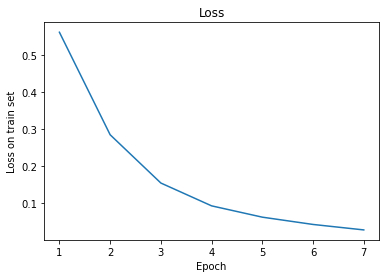

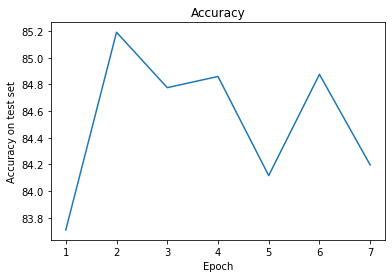

ClearML Task: created new task id=57b646088a644c3ab0b0e8ff37cd7430
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/57b646088a644c3ab0b0e8ff37cd7430/output/log
2022-01-15 12:55:03,057 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.707
Epoch 1, 2000/25000, loss: 0.682
Epoch 1, 3000/25000, loss: 0.683
Epoch 1, 4000/25000, loss: 0.673
Epoch 1, 5000/25000, loss: 0.665
Epoch 1, 6000/25000, loss: 0.647
Epoch 1, 7000/25000, loss: 0.647
Epoch 1, 8000/25000, loss: 0.627
Epoch 1, 9000/25000, loss: 0.597
Epoch 1, 10000/25000, loss: 0.623
Epoch 1, 11000/25000, loss: 0.606
Epoch 1, 12000/25000, loss: 0.608
Epoch 1, 13000/25000, loss: 0.561
Epoch 1, 14000/25000, loss: 0.532
Epoch 1, 15000/25000, loss: 0.523
Epoch 1, 16000/25000, loss: 0.505
Epoch 1, 17000/25000, loss: 0.503
Epoch 1, 18000/25000, loss:

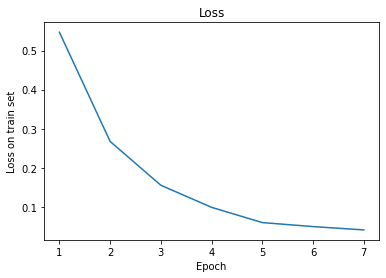

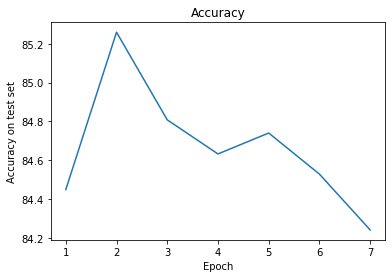

ClearML Task: created new task id=432ecaefa5644084b58ece57854e5c59
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/432ecaefa5644084b58ece57854e5c59/output/log
2022-01-15 13:26:02,655 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.696
Epoch 1, 2000/25000, loss: 0.681
Epoch 1, 3000/25000, loss: 0.654
Epoch 1, 4000/25000, loss: 0.656
Epoch 1, 5000/25000, loss: 0.644
Epoch 1, 6000/25000, loss: 0.645
Epoch 1, 7000/25000, loss: 0.618
Epoch 1, 8000/25000, loss: 0.559
Epoch 1, 9000/25000, loss: 0.572
Epoch 1, 10000/25000, loss: 0.553
Epoch 1, 11000/25000, loss: 0.524
Epoch 1, 12000/25000, loss: 0.492
Epoch 1, 13000/25000, loss: 0.540
Epoch 1, 14000/25000, loss: 0.444
Epoch 1, 15000/25000, loss: 0.429
Epoch 1, 16000/25000, loss: 0.411
Epoch 1, 17000/25000, loss: 0.361
Epoch 1, 18000/25000, loss:

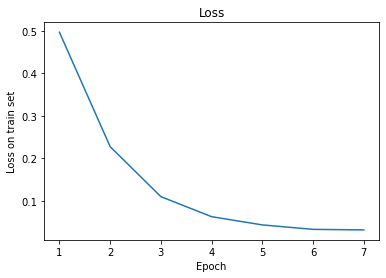

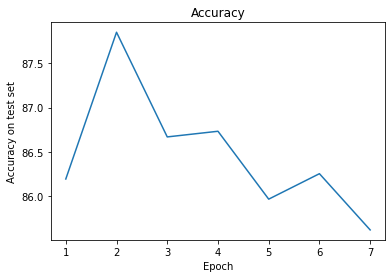

In [48]:
lrs = [0.005, 0.01]
hidden_dims = [8, 16, 32]
epochs = 7
log_interval = 20
batch_size = 50
task_n = 0
for lr in lrs:
    for hidden_dim in hidden_dims:
        task_prefix = '2fc'
        task_name = task_prefix + '_' + str(task_n)
        task = Task.init(project_name='homework', task_name=task_name)
        task.set_parameters({'epochs':epochs, 'lr': lr, 'log_interval':log_interval, 
                             'batch_size':batch_size, 'hidden_dim':hidden_dim})
        logger = task.get_logger()
        trainer = LSTMTrainer(batch_size=batch_size, hidden_dim=hidden_dim, lr=lr)
        accs, losses = trainer.train(epochs=epochs, log_interval=log_interval, logger=logger, mode=1)
        
        plt.plot(range(1,epochs+1), losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss on train set')
        plt.title('Loss')
        plt.show()
        plt.plot(range(1,epochs+1), accs)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy on test set')
        plt.title('Accuracy')
        plt.show()
        
        task.close()
        task_n += 1

ClearML Task: created new task id=457dc5228f7b469ca2dda0f7993f1114
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/457dc5228f7b469ca2dda0f7993f1114/output/log
2022-01-15 14:31:13,153 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.698
Epoch 1, 2000/25000, loss: 0.687
Epoch 1, 3000/25000, loss: 0.686
Epoch 1, 4000/25000, loss: 0.672
Epoch 1, 5000/25000, loss: 0.669
Epoch 1, 6000/25000, loss: 0.656
Epoch 1, 7000/25000, loss: 0.641
Epoch 1, 8000/25000, loss: 0.659
Epoch 1, 9000/25000, loss: 0.603
Epoch 1, 10000/25000, loss: 0.588
Epoch 1, 11000/25000, loss: 0.650
Epoch 1, 12000/25000, loss: 0.649
Epoch 1, 13000/25000, loss: 0.627
Epoch 1, 14000/25000, loss: 0.601
Epoch 1, 15000/25000, loss: 0.566
Epoch 1, 16000/25000, loss: 0.563
Epoch 1, 17000/25000, loss: 0.567
Epoch 1, 18000/25000, loss:

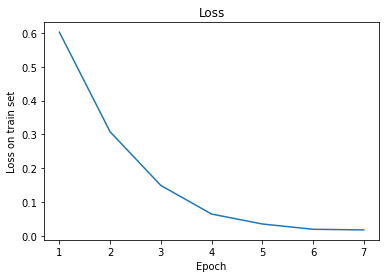

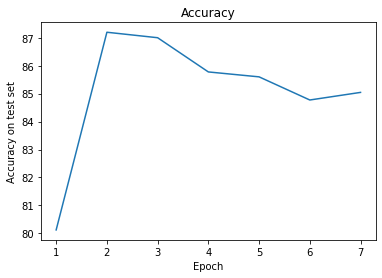

ClearML Task: created new task id=6cc6dfa865534d35bb4331cf6dd61b81
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/6cc6dfa865534d35bb4331cf6dd61b81/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-01-15 15:01:03,968 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 1000/25000, loss: 0.695
Epoch 1, 2000/25000, loss: 0.685
Epoch 1, 3000/25000, loss: 0.673
Epoch 1, 4000/25000, loss: 0.666
Epoch 1, 5000/25000, loss: 0.624
Epoch 1, 6000/25000, loss: 0.716
Epoch 1, 7000/25000, loss: 0.680
Epoch 1, 8000/25000, loss: 0.658
Epoch 1, 9000/25000, loss: 0.661
Epoch 1, 10000/25000, loss: 0.636
Epoch 1, 11000/25000, loss: 0.615
Epoch 1, 12000/25000, loss: 0.575
Epoch 1, 13000/25000, loss: 0.585
Epoch 1, 14000/25000, loss: 0.564
Epoch 1, 15000/25000, loss: 0.546
Epoch 1, 16000/25000, loss: 0.596
Epoch 1, 17000/25000, loss: 0.565
Epoch 1, 18000/25000, loss:

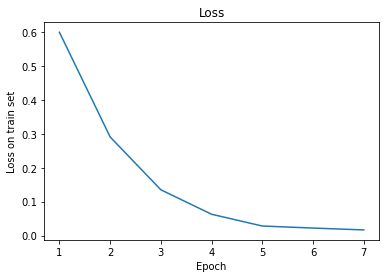

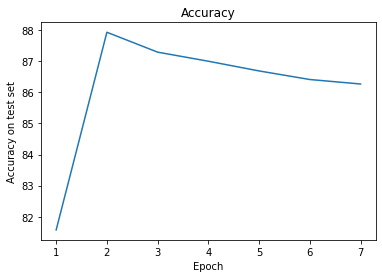

ClearML Task: created new task id=1a9e86ce0ef346389a75aac02132dc4d
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/1a9e86ce0ef346389a75aac02132dc4d/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-01-15 15:38:47,736 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 1000/25000, loss: 0.701
Epoch 1, 2000/25000, loss: 0.682
Epoch 1, 3000/25000, loss: 0.686
Epoch 1, 4000/25000, loss: 0.662
Epoch 1, 5000/25000, loss: 0.665
Epoch 1, 6000/25000, loss: 0.650
Epoch 1, 7000/25000, loss: 0.640
Epoch 1, 8000/25000, loss: 0.636
Epoch 1, 9000/25000, loss: 0.581
Epoch 1, 10000/25000, loss: 0.604
Epoch 1, 11000/25000, loss: 0.563
Epoch 1, 12000/25000, loss: 0.592
Epoch 1, 13000/25000, loss: 0.541
Epoch 1, 14000/25000, loss: 0.480
Epoch 1, 15000/25000, loss: 0.455
Epoch 1, 16000/25000, loss: 0.448
Epoch 1, 17000/25000, loss: 0.479
Epoch 1, 18000/25000, loss:

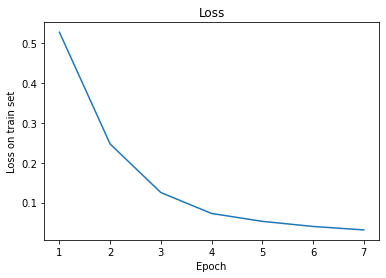

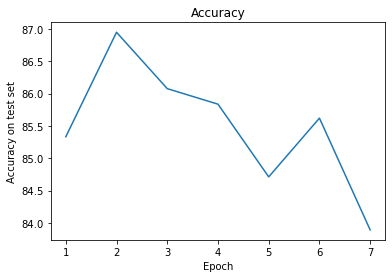

ClearML Task: created new task id=3e0ac67e15304de686cd5ad58987ca6d
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/3e0ac67e15304de686cd5ad58987ca6d/output/log
2022-01-15 16:07:24,353 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.696
Epoch 1, 2000/25000, loss: 0.678
Epoch 1, 3000/25000, loss: 0.660
Epoch 1, 4000/25000, loss: 0.665
Epoch 1, 5000/25000, loss: 0.648
Epoch 1, 6000/25000, loss: 0.645
Epoch 1, 7000/25000, loss: 0.622
Epoch 1, 8000/25000, loss: 0.585
Epoch 1, 9000/25000, loss: 0.579
Epoch 1, 10000/25000, loss: 0.640
Epoch 1, 11000/25000, loss: 0.600
Epoch 1, 12000/25000, loss: 0.545
Epoch 1, 13000/25000, loss: 0.512
Epoch 1, 14000/25000, loss: 0.455
Epoch 1, 15000/25000, loss: 0.469
Epoch 1, 16000/25000, loss: 0.465
Epoch 1, 17000/25000, loss: 0.361
Epoch 1, 18000/25000, loss:

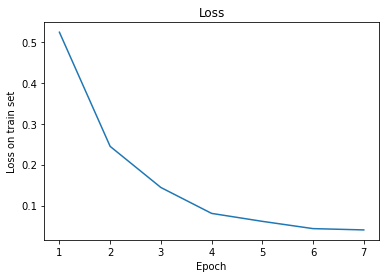

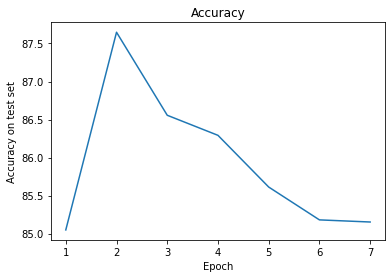

In [53]:
lrs = [0.005, 0.01]
hidden_dims = [16, 32]
epochs = 7
log_interval = 20
batch_size = 50
task_n = 0
for lr in lrs:
    for hidden_dim in hidden_dims:
        task_prefix = 'dropout'
        task_name = task_prefix + '_' + str(task_n)
        task = Task.init(project_name='homework', task_name=task_name)
        task.set_parameters({'epochs':epochs, 'lr': lr, 'log_interval':log_interval, 
                             'batch_size':batch_size, 'hidden_dim':hidden_dim})
        logger = task.get_logger()
        trainer = LSTMTrainer(batch_size=batch_size, hidden_dim=hidden_dim, lr=lr)
        accs, losses = trainer.train(epochs=epochs, log_interval=log_interval, logger=logger, mode=2)
        
        plt.plot(range(1,epochs+1), losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss on train set')
        plt.title('Loss')
        plt.show()
        plt.plot(range(1,epochs+1), accs)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy on test set')
        plt.title('Accuracy')
        plt.show()
        
        task.close()
        task_n += 1

ClearML Task: created new task id=98bbd59c3ca343bcbd3fce9e3613ddf6
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/98bbd59c3ca343bcbd3fce9e3613ddf6/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-01-15 16:47:12,656 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 1000/25000, loss: 0.696
Epoch 1, 2000/25000, loss: 0.684
Epoch 1, 3000/25000, loss: 0.666
Epoch 1, 4000/25000, loss: 0.661
Epoch 1, 5000/25000, loss: 0.659
Epoch 1, 6000/25000, loss: 0.665
Epoch 1, 7000/25000, loss: 0.641
Epoch 1, 8000/25000, loss: 0.617
Epoch 1, 9000/25000, loss: 0.645
Epoch 1, 10000/25000, loss: 0.675
Epoch 1, 11000/25000, loss: 0.631
Epoch 1, 12000/25000, loss: 0.601
Epoch 1, 13000/25000, loss: 0.562
Epoch 1, 14000/25000, loss: 0.616
Epoch 1, 15000/25000, loss: 0.590
Epoch 1, 16000/25000, loss: 0.638
Epoch 1, 17000/25000, loss: 0.578
Epoch 1, 18000/25000, loss:

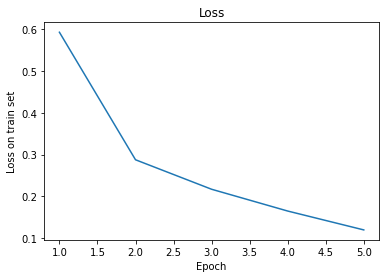

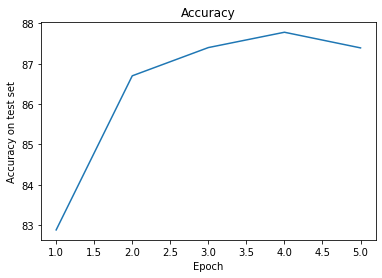

ClearML Task: created new task id=52c6d902384d4c91bd47f3b6e322ebc3
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/52c6d902384d4c91bd47f3b6e322ebc3/output/log
2022-01-15 17:13:23,305 - clearml.Task - INFO - No repository found, storing script code instead
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1, 1000/25000, loss: 0.695
Epoch 1, 2000/25000, loss: 0.685
Epoch 1, 3000/25000, loss: 0.673
Epoch 1, 4000/25000, loss: 0.666
Epoch 1, 5000/25000, loss: 0.624
Epoch 1, 6000/25000, loss: 0.716
Epoch 1, 7000/25000, loss: 0.680
Epoch 1, 8000/25000, loss: 0.658
Epoch 1, 9000/25000, loss: 0.661
Epoch 1, 10000/25000, loss: 0.636
Epoch 1, 11000/25000, loss: 0.615
Epoch 1, 12000/25000, loss: 0.575
Epoch 1, 13000/25000, loss: 0.585
Epoch 1, 14000/25000, loss: 0.564
Epoch 1, 15000/25000, loss: 0.546
Epoch 1, 16000/25000, loss: 0.596
Epoch 1, 17000/25000, loss: 0.565
Epoch 1, 18000/25000, loss:

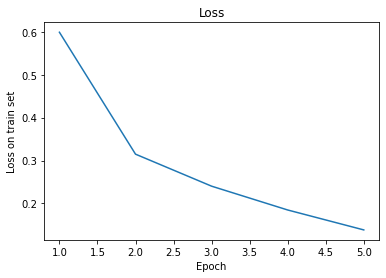

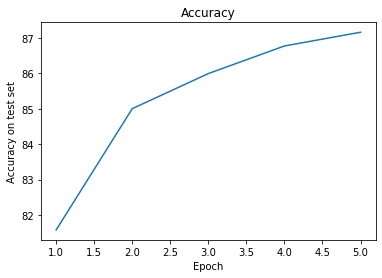

In [55]:
lr = (0.005, 0.001)
hidden_dim = 32
epochs = 5
log_interval = 20
batch_size = 50
task_n = 1

for mode in [1, 2]:
    task_prefix = 'variable_lr'
    task_name = task_prefix + '_' + str(task_n)
    task = Task.init(project_name='homework', task_name=task_name)
    task.set_parameters({'epochs':epochs, 'lr': lr, 'log_interval':log_interval, 
                         'batch_size':batch_size, 'hidden_dim':hidden_dim, 'mode':mode})
    logger = task.get_logger()
    trainer = LSTMTrainer(batch_size=batch_size, hidden_dim=hidden_dim, lr=lr)
    accs, losses = trainer.train(epochs=epochs, log_interval=log_interval, logger=logger, mode=mode)

    plt.plot(range(1,epochs+1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss on train set')
    plt.title('Loss')
    plt.show()
    plt.plot(range(1,epochs+1), accs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy on test set')
    plt.title('Accuracy')
    plt.show()

    task.close()
    task_n += 1

ClearML Task: created new task id=1d409b2484dc4c0f8fc5b6326ed13294
ClearML results page: https://app.community.clear.ml/projects/efc8e940f79848bdadf83e7ae74b312b/experiments/1d409b2484dc4c0f8fc5b6326ed13294/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
2022-01-15 18:03:33,882 - clearml.Task - INFO - No repository found, storing script code instead
Epoch 1, 1000/25000, loss: 0.695
Epoch 1, 2000/25000, loss: 0.685
Epoch 1, 3000/25000, loss: 0.673
Epoch 1, 4000/25000, loss: 0.666
Epoch 1, 5000/25000, loss: 0.624
Epoch 1, 6000/25000, loss: 0.716
Epoch 1, 7000/25000, loss: 0.680
Epoch 1, 8000/25000, loss: 0.658
Epoch 1, 9000/25000, loss: 0.661
Epoch 1, 10000/25000, loss: 0.636
Epoch 1, 11000/25000, loss: 0.615
Epoch 1, 12000/25000, loss: 0.575
Epoch 1, 13000/25000, loss: 0.585
Epoch 1, 14000/25000, loss: 0.564
Epoch 1, 15000/25000, loss: 0.546
Epoch 1, 16000/25000, loss: 0.596
Epoch 1, 17000/25000, loss: 0.565
Epoch 1, 18000/25000, loss:

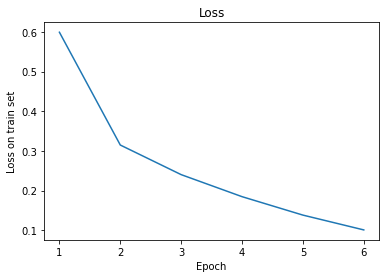

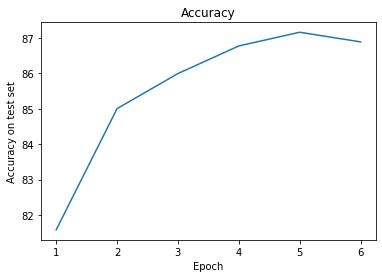

In [67]:
lr = (0.005, 0.001)
hidden_dim = 32
epochs = 10
log_interval = 20
batch_size = 50
task_n = 1

mode = 2
task = Task.init(project_name='homework', task_name='variable_lr_2')
task.set_parameters({'epochs':epochs, 'lr': lr, 'log_interval':log_interval, 
                     'batch_size':batch_size, 'hidden_dim':hidden_dim, 'mode':mode,
                     'early_stopping':True})
logger = task.get_logger()
trainer = LSTMTrainer(batch_size=batch_size, hidden_dim=hidden_dim, lr=lr)
accs, losses = trainer.train(epochs=epochs, log_interval=log_interval, logger=logger, 
                             mode=mode, early_stopping=True)

epochs = len(accs)
plt.plot(range(1,epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss on train set')
plt.title('Loss')
plt.show()
plt.plot(range(1,epochs+1), accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy on test set')
plt.title('Accuracy')
plt.show()

task.close()
task_n += 1